In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# My own code for this project. 
from Kernel import *

## Problem description and dataset

The following data set comes from a competition hosted on DrivenData. One must predict the number of dengue fever cases every week, based on a number of climate variables, such as humidity, temperature, precipitation, etc. See <br />
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

There are two cities, for which one must predict the number of cases: San Juan, Puerto Rico, and Iquitos, Peru. Here is what the data set look like. 

In [3]:
city = 'sj'
Xy = pd.read_pickle("Xy_" + city +".pkl")
Xy.sample(5)

features        vegetation                                        precipit_mm  \
measurements       ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw precipitation_amt_mm   
year weekofyear                                                                 
1997 21            0.07980  0.106533  0.159033  0.098733                 0.00   
2007 7            -0.07520 -0.071940  0.243943  0.192314                 0.00   
2001 19            0.03710  0.070500  0.047814  0.063743                59.89   
2006 29            0.04735  0.028167  0.196686  0.161543                16.61   
2005 21            0.04760  0.067350  0.096600  0.087314               156.94   

features                   avg_temp_c                        \
measurements    reanalysis_air_temp_c reanalysis_avg_temp_c   
year weekofyear                                               
1997 21                     26.091429             26.235714   
2007 7                      25.294286             25.435714   
2001 19                     26.268571             26.350000   
2006 29                     27.094286             27.071429   
2005 21                     26.655714             26.885714   

features        reanalysis_dew_point_temp_c                max_temp_c  \
measurements    reanalysis_dew_point_temp_c reanalysis_max_air_temp_c   
year weekofyear                                                         
1997 21                           21.511429                     27.95   
2007 7                            20.677143                     28.25   
2001 19                           22.215714                     28.85   
2006 29                           23.437143                     29.15   
2005 21                           23.750000                     29.85   

features                       min_temp_c  ...  \
measurements    reanalysis_min_air_temp_c  ...   
year weekofyear                            ...   
1997 21                             24.65  ...   
2007 7                              22.65  ...   
2001 19                             24.25  ...   
2006 29                             25.15  ...   
2005 21                             23.95  ...   

features        reanalysis_relative_humidity_percent  \
measurements    reanalysis_relative_humidity_percent   
year weekofyear                                        
1997 21                                    75.982857   
2007 7                                     75.754286   
2001 19                                    78.567143   
2006 29                                    80.538571   
2005 21                                    84.335714   

features        reanalysis_specific_humidity_g_per_kg   diur_temp_rng_c  \
measurements    reanalysis_specific_humidity_g_per_kg reanalysis_tdtr_k   
year weekofyear                                                           
1997 21                                     15.997143          2.428571   
2007 7                                      15.184286          3.457143   
2001 19                                     16.771429          3.200000   
2006 29                                     18.011429          2.557143   
2005 21                                     18.485714          3.071429   

features                avg_temp_c         diur_temp_rng_c         max_temp_c  \
measurements    station_avg_temp_c station_diur_temp_rng_c station_max_temp_c   
year weekofyear                                                                 
1997 21                  27.585714                7.085714               32.2   
2007 7                   26.157143                7.600000               32.2   
2001 19                  27.485714                7.057143               32.2   
2006 29                  27.485714                6.471429               31.7   
2005 21                  28.385714                6.657143               35.0   

features                min_temp_c       precipit_mm labels week_number  
measurements    station_min_temp_c station_precip_mm                     
year weekofye

In [4]:
features = list(Xy.columns)
del features[-2:]
d = len(features)
d

19

In [5]:
print('Columns are different measurements of the following climate variables:')
for f in sorted(set(Xy.columns.get_level_values(0))):
    print(f)

Columns are different measurements of the following climate variables:
avg_temp_c
diur_temp_rng_c
labels
max_temp_c
min_temp_c
precipit_mm
reanalysis_dew_point_temp_c
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_specific_humidity_g_per_kg
vegetation
week_number


## Modelling

Looking at the data, it is apparent that cases of dengue fever exhibit a periodicity. 

In [6]:
cases = Xy['labels']

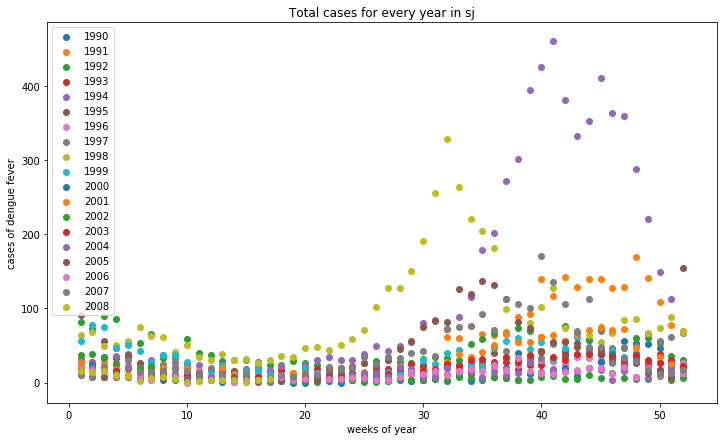

In [7]:
years = set(cases.index.get_level_values(0))
plt.rcParams['figure.figsize'] = [12, 7]
plt.xlabel('weeks of year')
plt.ylabel('cases of dengue fever')
plt.title('Total cases for every year in '+ city)
for year in years:
    plt.scatter(cases.loc[year].index, cases.loc[(year,)])

plt.legend([str(year) for year in years])
plt.show()

There seems to be a yearly periodicity, hence the average number of cases per week can be taken as a baseline model. 

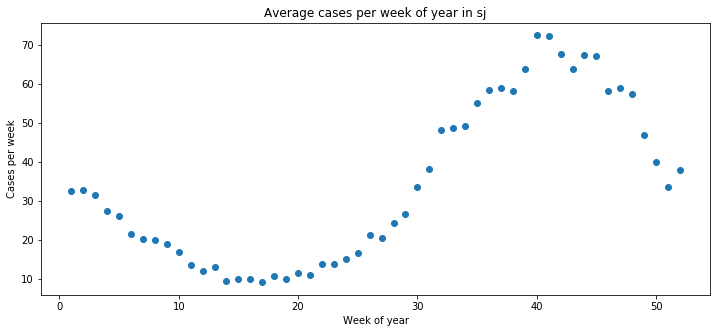

In [8]:
cases_by_week = cases.groupby(cases.index.get_level_values(1)) #group by week of year
avg_cases = cases_by_week.aggregate(np.mean) # average tot_case for any given week
plt.rcParams['figure.figsize'] = [12, 5]
plt.xlabel('Week of year')
plt.ylabel('Cases per week')
plt.title('Average cases per week of year in '+city)
plt.scatter(avg_cases.index, avg_cases)
plt.show()

As the number of dengue fever case is inherently a probabilistic phenomenon, it is natural to use baysian inference to study it, and model denge fever cases as a Gaussian process. This idea is not new, here is a [paper](https://arxiv.org/abs/1608.03343) also using this approach. 

To take into account this periodicity, as well as the climate features, the kernel function I have been using for the Gaussian process is the following. Let $x_i$ be the climate variables recorded during week $i$ (counted from the first week in the database). Define 
$$
k(x_i, x_j) = \sigma_{time}^2 k_{time}(i, j) + \sigma_{per}^2 k_{per}(i, j) + \sigma_{cli}^2 k_{cli}(x_i, x_k),
$$
where

$$
k_{time}(i, j) = m \left(\frac{|i-j|}{l_{time}}\right), \hspace{.5in} m(t) = (1+ \sqrt{5}t + 5/3 t^2) e^{-\sqrt{5}t},
$$
enforces the assumption that nearby weeks should be correlated;

$$
k_{per}(i, j) = m \left(\frac{|i-j|}{l_{mat}}\right) \exp \left(\frac{-2}{l_{per}^2}\sin^2 \left(\pi \frac{|i-j|}{p}\right) \right)
$$
models the periodicity observed in dengue fever cases;

$$
k_{cli}(x_i, x_k) = \exp \left( \sum_{d=1}^D l_d^2 \; (x_i(d) - x_j(d))^2 \right)
$$
ensures that week with similar climate variables must be correlated. 

In [10]:
n_time = 4 # parameters in k_time and k_per
n_sig2 = 3 # weight of each kernel component
n = n_time + n_sig2 + d

## Training

Fitting the parameters to minimize the log-likelihood. 

In [11]:
Xy = Xy.loc[1999:2004] # Using a smaller subset of the whole data set. 
from sklearn.model_selection import train_test_split
Xy_train, Xy_test = train_test_split(Xy, train_size=0.7,test_size=0.3, shuffle = False)

In [12]:
X, Y, gamma = fitting_preprocess(Xy_train, features) 
Xs = fitting_preprocess(Xy_test, features)[0]
X_tot = fitting_preprocess(Xy, features)[0]
Y_test = Xy_test[[('labels', '')]].values
Y_train = Xy_train[[('labels', '')]].values

#### Baseline model

In [13]:
#Baseline model (averages of cases per week)
Y_base = pd.Series(index = Xy_test.index)
for year, week in Y_base.index:
    Y_base[(year, week)] = avg_cases[week]

Starting from previously recorded optimal parameters to speed up the minimizing process. 

In [14]:
opt_param = pd.read_pickle('opt_param.pkl')
opt_param.tail(3)

,l_mat,l_mat2,p,l_per,sig2_mat,sig2_per,sig2_met,l2_ndvi_ne,l2_ndvi_nw,l2_ndvi_se,...,l2_reanalysis_tdtr_k,l2_station_avg_temp_c,l2_station_diur_temp_rng_c,l2_station_max_temp_c,l2_station_min_temp_c,l2_station_precip_mm,training_set,testing_set,score,remarks
7,9.255868,499.965723,52.013168,1.265100,0.358288,0.644478,0.00001,1.878305,1.119254,1.988075,...,1.768296,1.071068,1.084255,1.634136,1.444107,1.710407,"2005:2009, 0.8","2005:2009, 0.2",0.447104,"shuffle, iquitos"
8,18.301442,499.720484,53.137365,3.212954,0.645613,2.770228,0.00001,1.597245,1.112004,1.393452,...,1.961334,1.798895,1.807736,1.920370,1.025214,1.982668,"1998:2005, 0.7","1998:2005, 0.3",-0.148030,"shuffle, sj"
9,35.040531,499.910082,52.600084,3.149646,0.873746,2.209523,0.00001,1.985395,1.215838,1.898725,...,1.332265,1.138713,1.028104,1.549585,1.420323,1.579052,"1999:2004, 0.7","1999:2004, 0.3",0.432073,"shuffle, sj"


In [15]:
theta = opt_param.values[9,:-4].astype('float')
#l2_time = np.array([30.0, 500.0, 52.0, 0.1])
#l2_time = np.array([10.0, 100.0, 52.0, 0.1])
#sig2 = np.ones(3)
#l2_cli = 1+np.random.rand(d)
#theta = np.hstack([l2_time, sig2, l2_cli])

Using the SLSQP method in scipy.optimize to get the parameters minimizing the negative log-likelihood. 

In [ ]:
from scipy.optimize import minimize

In [ ]:
%%time
nll = nll_fn(X, Y, 0.2) 
bounds = [(1e-05, None) for i in range(n)]
res = minimize(nll, theta, method='SLSQP', bounds = bounds, options = {'disp':True})

In [ ]:
theta = res.x

## Result

In [16]:
Y_minus, Y_tot, Y_plus = Y_pred(X_tot, X, Y, gamma, theta, std_dev = True)
X_tot[:,0].sort()

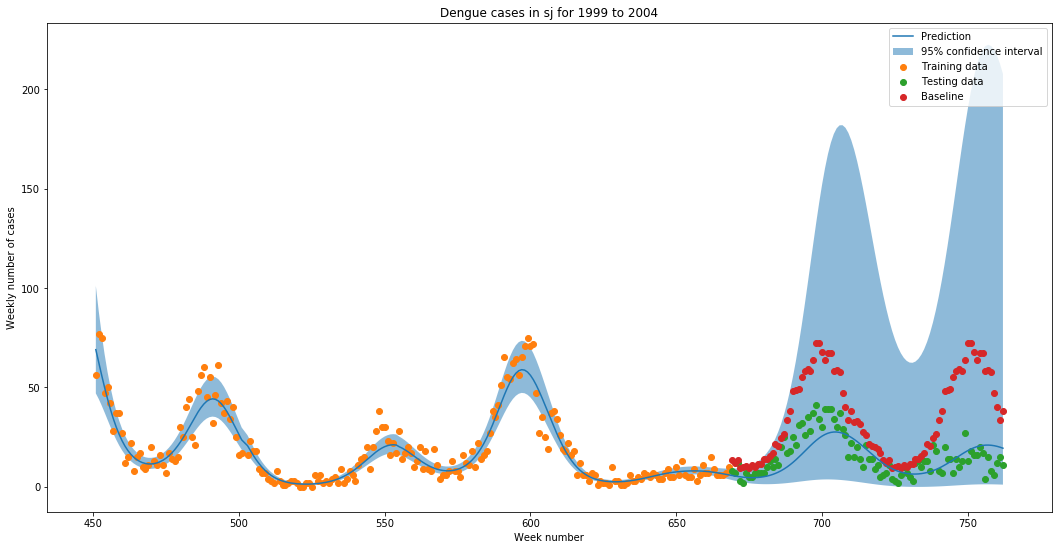

In [17]:
years = Xy.index.get_level_values(0)
plt.rcParams['figure.figsize'] = [18, 9]
plt.xlabel('Week number')
plt.ylabel('Weekly number of cases')
plt.title('Dengue cases in '+ city + ' for ' + str(years[0]) + ' to ' + str(years[-1]))
plt.fill_between(X_tot[:,0], Y_plus, Y_minus, label ='95% confidence interval',  alpha=0.5)
plt.plot(X_tot[:,0], Y_tot, label = 'Prediction')
plt.scatter(X[:,0], Y_train, label = 'Training data')
plt.scatter(Xs[:,0], Y_test, label = 'Testing data')
plt.scatter(Xs[:,0], Y_base, label = 'Baseline')
plt.legend()
plt.show()

## Score of  model

The score is a number $\leq 1$ measuring how well the model generalizes to the testing data. 

$$
{\rm score} = 1- \frac{\sum (Y_{test} - Y_{pred})^2}{\sum (Y_{test} - \mu(Y_{test}))^2}, 
\hspace{.5in} \mu(Y_{test}) = {\rm mean \: of}\: Y_{test}. 
$$

Score of GP model

In [18]:
Ys = Y_pred(Xs, X, Y, gamma, theta).reshape(-1,1)
score(Y_test, Ys)

0.43207273089899145

Score of baseline model

In [19]:
Y_base = Y_base.values.reshape(-1,1)
score(Y_test, Y_base)

-5.3226905963352049

Recording optimal parameters for further use. 

In [ ]:
new_line = list(theta) + ['1999:2005, 0.7', '1999:2005, 0.3', 0.432072730, 'shuffle, '+city ]
pd_new_line = pd.DataFrame([new_line], columns = opt_param.columns)
opt_param = opt_param.append(pd_new_line, ignore_index=True)
opt_param.to_pickle('opt_param.pkl')

## Interpreting the parameters

The optimal parameters are 

In [20]:
l2_time = theta[:n_time]
sig2 = theta[n_time:n_time+n_sig2]
l2_cli = theta[n_time+n_sig2:]
print('l_time = ', l2_time[0])
print('l_mat = ', l2_time[1])
print('p = ', l2_time[2])
print('l_per = ', l2_time[3])
print('sig2_time = ', sig2[0])
print('sig2_per = ', sig2[1])
print('sig2_cli = ', sig2[2])
for i in range(d):
    print('l_' + features[i][1] + ' =', np.sqrt(l2_cli[i]))

l_time =  35.0405309797
l_mat =  499.910082136
p =  52.6000843692
l_per =  3.14964617106
sig2_time =  0.87374609908
sig2_per =  2.20952263241
sig2_cli =  1.00005902438e-05
l_ndvi_ne = 1.40904062282
l_ndvi_nw = 1.10265026929
l_ndvi_se = 1.37794238212
l_ndvi_sw = 1.22672472569
l_precipitation_amt_mm = 1.21435703814
l_reanalysis_air_temp_c = 1.28782177233
l_reanalysis_avg_temp_c = 1.15303559539
l_reanalysis_dew_point_temp_c = 1.14832317818
l_reanalysis_max_air_temp_c = 1.33278329481
l_reanalysis_min_air_temp_c = 1.31975927386
l_reanalysis_precip_amt_kg_per_m2 = 1.22738253172
l_reanalysis_relative_humidity_percent = 1.1377224794
l_reanalysis_specific_humidity_g_per_kg = 1.40598377918
l_reanalysis_tdtr_k = 1.15423774916
l_station_avg_temp_c = 1.06710512839
l_station_diur_temp_rng_c = 1.01395478545
l_station_max_temp_c = 1.2448232659
l_station_min_temp_c = 1.19177313299
l_station_precip_mm = 1.25660328598


One sees that the weight $\sigma_{cli}^2$ of the climate variables is almost negligible! Surprising, but can explained in the following way:

Climate in San Juan and Iquitos (or in most places on earth) exhibits a yearly periodicity, thus climate is already "encoded" in the periodic part of the kernel. 

Thus most important feature predict the number of cases is just the date!

Model not as performant for Iquitos?

## Further directions

Use sparse method to speed up calculations

In [ ]:
t = np.linspace(0,10, 1000)
plt.plot(t, Matern(t, 1.0))
plt.show()

In [ ]:
t = np.linspace(0,10, 1000)
plt.plot(t, TimeCov(t, [1.0, 0.4, 0.1]))
plt.show()